
## Evaluating the performance of a hybrid power plant with P2X using HyDesign

In this notebook we will evaluate a hybrid power plant design in a specific location.

A hybrid power plant design consists on selecting the following parameters:

**Wind Plant design:**

1. Number of wind turbines in the wind plant [-] (`Nwt`)
2. Wind power installation density [MW/km2] (`wind_MW_per_km2`): This parameter controls how closely spaced are the turbines, which in turns affect how much wake losses are present.

**PV Plant design:**

3. Solar plant power capacity [MW] (`solar_MW`)

**Battery Storage design:**

4. Battery power [MW] (`b_P`)
5. Battery energy capacity in hours [MWh] (`b_E_h `): Battery storage capacity in hours of full battery power (`b_E = b_E_h * b_P `). 
6. Cost of battery power fluctuations in peak price ratio [-] (`cost_of_batt_degr`): This parameter controls how much penalty is given to do ramps in battery power in the HPP operation.

**Electrolyzer design:**

7. Electrolyzer capacity [MW] (`ptg_MW`)
8. H2 storage capacity [kg] (`HSS_kg`)

##
**Imports**

Install hydesign if needed.
Import basic libraries. 
Import HPP model assembly class.
Import the examples file path.

In [118]:
# Install hydesign if needed
import importlib
if not importlib.util.find_spec("hydesign"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/hydesign.git   

In [119]:
import os
import time
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hydesign.assembly.hpp_assembly_P2X import hpp_model_P2X as hpp_model
from hydesign.examples import examples_filepath

##
**Specifying the site**

Hydesign, provides example data from several sites in India and Europe. 

The site coordinates (longitude, latitude, and altitude) are given in `examples_sites.csv`.

In [120]:
examples_sites = pd.read_csv(f'{examples_filepath}examples_sites.csv', index_col=0, sep=';')
examples_sites

,case,name,longitude,latitude,altitude,input_ts_fn,sim_pars_fn,price_fn,price_col,H2_demand_col,input_HA_ts_fn,price_up_ts,price_dwn_ts
0,India,Indian_site_good_wind,77.500226,8.334294,679.803454,India/GWA2/input_ts_Indian_site_good_wind.csv,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price,India/H2_demand.csv,NaN,NaN,NaN
1,India,Indian_site_good_solar,68.542204,23.542099,29.883557,India/GWA2/input_ts_Indian_site_good_solar.csv,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price,India/H2_demand.csv,NaN,NaN,NaN
2,India,Indian_site_bad_solar_bad_wind,77.916878,17.292316,627.424643,India/GWA2/input_ts_Indian_site_bad_solar_bad_...,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price,India/H2_demand.csv,NaN,NaN,NaN
3,Europe,France_good_solar,4.229736,44.422011,204.000000,Europe/GWA2/input_ts_France_good_solar.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R,Europe/H2_demand.csv,NaN,NaN,NaN
4,Europe,France_good_wind,-0.864258,48.744116,302.000000,Europe/GWA2/input_ts_France_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R,Europe/H2_demand.csv,NaN,NaN,NaN
5,Europe,France_bad_solar_n_wind,2.167969,47.428087,140.000000,Europe/GWA2/input_ts_France_bad_solar_n_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R,Europe/H2_demand.csv,NaN,NaN,NaN
6,Europe,Germany_bad_solar_n_wind,10.766602,49.310798,442.000000,Europe/GWA2/input_ts_Germany_bad_solar_n_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DE_ME,Europe/H2_demand.csv,NaN,NaN,NaN
7,Europe,Germany_good_wind,7.873535,53.287111,5.000000,Europe/GWA2/input_ts_Germany_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DE_NW,Europe/H2_demand.csv,NaN,NaN,NaN
8,Europe,Denmark_good_solar,11.813965,55.397760,42.000000,Europe/GWA2/input_ts_Denmark_good_solar.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DK_E,Europe/H2_demand.csv,NaN,NaN,NaN
9,Europe,Denmark_good_wind,8.594398,56.227322,85.000000,Europe/GWA2/input_ts_Denmark_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DK_W,Europe/H2_demand.csv,NaN,NaN,NaN


##
**Select a site to run**

In [121]:
name = 'Marijampole'

ex_site = examples_sites.loc[examples_sites.name == name]

longitude = ex_site['longitude'].values[0]
latitude = ex_site['latitude'].values[0]
altitude = ex_site['altitude'].values[0]

In [122]:
# Weather data and Price data
input_ts_fn = examples_filepath+ex_site['input_ts_fn'].values[0]

input_ts = pd.read_csv(input_ts_fn, index_col=0, parse_dates=True)

required_cols = [col for col in input_ts.columns if 'WD' not in col]
input_ts = input_ts.loc[:,required_cols]
input_ts

,WS_1,WS_50,WS_100,WS_150,WS_200,temp_air_1,ghi,dni,dhi,Price
Unnamed: 0,,,,,,,,,,
2012-01-01 00:00:00,0.0100,3.1421,4.7760,5.9066,6.5347,270.6143,0.01,0.01,0.01,31.163
2012-01-01 01:00:00,0.4483,3.3321,4.8023,5.8109,6.3627,270.5281,0.01,0.01,0.01,31.163
2012-01-01 02:00:00,0.2514,3.1555,4.6463,5.6722,6.2366,270.2264,0.01,0.01,0.01,31.163
2012-01-01 03:00:00,0.5311,3.5833,5.1836,6.2953,6.9171,269.9671,0.01,0.01,0.01,31.163
2012-01-01 04:00:00,1.1617,4.3300,6.0025,7.1680,7.8234,270.0519,0.01,0.01,0.01,31.163
...,...,...,...,...,...,...,...,...,...,...
2012-12-30 19:00:00,1.0274,6.3462,8.5950,10.0071,10.6464,274.6222,0.01,0.01,0.01,35.875
2012-12-30 20:00:00,1.2988,6.9335,9.2803,10.7429,11.3920,275.3689,0.01,0.01,0.01,33.971
2012-12-30 21:00:00,1.2801,7.0699,9.4592,10.9412,11.5907,275.2330,0.01,0.01,0.01,33.105


In [123]:
# Hydrogen demand data, when H2 offtake is infinite -> make H2_demand values very high (1e6) in H2_demand.csv file and penalty_H2 as '0' in hpp_pars.yml file
H2_demand_fn = examples_filepath+ex_site['H2_demand_col'].values[0]

H2_demand_ts = pd.read_csv(H2_demand_fn, index_col=0, parse_dates=True)
H2_demand_ts

,H2_demand
2012-01-01 00:00:00,10000
2012-01-01 01:00:00,10000
2012-01-01 02:00:00,10000
2012-01-01 03:00:00,10000
2012-01-01 04:00:00,10000
...,...
2012-12-31 19:00:00,10000
2012-12-31 20:00:00,10000
2012-12-31 21:00:00,10000
2012-12-31 22:00:00,10000


In [124]:
# Input data of technology's cost
sim_pars_fn = examples_filepath+ex_site['sim_pars_fn'].values[0]

with open(sim_pars_fn) as file:
    sim_pars = yaml.load(file, Loader=yaml.FullLoader)

print(sim_pars_fn)    
sim_pars

/opt/anaconda3/envs/hydesign/lib/python3.11/site-packages/hydesign/examples/Europe/hpp_pars.yml


{'G_MW': 300,
 'year': '2012',
 'N_life': 25,
 'wind_turbine_cost': 640000,
 'wind_civil_works_cost': 260000,
 'wind_fixed_onm_cost': 12600,
 'wind_variable_onm_cost': 1.35,
 'd_ref': 145,
 'hh_ref': 100,
 'p_rated_ref': 5.0,
 'wpp_efficiency': 1,
 'wind_deg_yr': [0, 25],
 'wind_deg': [0, 0.25],
 'share_WT_deg_types': 0.5,
 'solar_PV_cost': 110000,
 'solar_hardware_installation_cost': 100000,
 'solar_inverter_cost': 20000,
 'solar_fixed_onm_cost': 4500,
 'land_use_per_solar_MW': 0.01226,
 'tracking': 'No',
 'pv_deg_yr': [0, 1, 25],
 'pv_deg': [0.03, 0.03, 0.28],
 'latitude': None,
 'longitude': None,
 'altitude': None,
 'battery_energy_cost': 62000,
 'battery_power_cost': 16000,
 'battery_BOP_installation_commissioning_cost': 80000,
 'battery_control_system_cost': 2250,
 'battery_energy_onm_cost': 0,
 'battery_depth_of_discharge': 0.9,
 'battery_charge_efficiency': 0.985,
 'battery_price_reduction_per_year': 0.1,
 'min_LoH': 0.7,
 'n_full_power_hours_expected_per_day_at_peak_price': 0,

## 
**Initializing the HPP model**

Initialize the HPP model (hpp_model class) with the coordinates and the necessary input files.

In [125]:
hpp = hpp_model(
        latitude=latitude,
        longitude=longitude,
        altitude=altitude,
        num_batteries = 3,
        work_dir = './',
        sim_pars_fn = sim_pars_fn,
        input_ts_fn = input_ts_fn,
        H2_demand_fn = H2_demand_fn, 
)


Fixed parameters on the site
-------------------------------
longitude = 23.348694
latitude = 54.556137
altitude = 73.0


##
### Evaluating the HPP model

In [126]:
start = time.time()

clearance = 10
sp = 350
p_rated = 5
Nwt = 1
wind_MW_per_km2 = 7

solar_MW = 436
surface_tilt = 50
surface_azimuth = 180

DC_AC_ratio = 1.5
b_P = 0
b_E_h  = 3
cost_of_batt_degr = 10

ptg_MW = 180
HSS_kg = 0

x = [clearance, sp, p_rated, Nwt, wind_MW_per_km2, solar_MW, \
surface_tilt, surface_azimuth, DC_AC_ratio, b_P, b_E_h , cost_of_batt_degr, ptg_MW, HSS_kg]

outs = hpp.evaluate(*x)

hpp.print_design(x, outs)

end = time.time()
print(f'exec. time [min]:', (end - start)/60 )


Design:
---------------
clearance [m]: 10.000
sp [W/m2]: 350.000
p_rated [MW]: 5.000
Nwt: 1.000
wind_MW_per_km2 [MW/km2]: 7.000
solar_MW [MW]: 436.000
surface_tilt [deg]: 50.000
surface_azimuth [deg]: 180.000
DC_AC_ratio: 1.500
b_P [MW]: 0.000
b_E_h [h]: 3.000
cost_of_battery_P_fluct_in_peak_price_ratio: 10.000
ptg_MW [MW]: 180.000
HSS_kg [kg]: 0.000


NPV_over_CAPEX: 0.658
NPV [MEuro]: 227.941
IRR: 0.119
LCOE [Euro/MWh]: 33.125
LCOH [Euro/kg]: 7.913
Revenue [MEuro]: 919.763
CAPEX [MEuro]: 346.467
OPEX [MEuro]: 6.243
penalty lifetime [MEuro]: 0.000
AEP [GWh]: 165.361
GUF: 0.063
annual_H2 [tons]: 6072.334
annual_P_ptg [GWh]: 403.983
grid [MW]: 300.000
wind [MW]: 5.000
solar [MW]: 436.000
PtG [MW]: 180.000
HSS [kg]: 0.000
Battery Energy [MWh]: 0.000
Battery Power [MW]: 0.000
Total curtailment [GWh]: 0.000
Awpp [km2]: 0.714
Apvp [km2]: 5.345
Rotor diam [m]: 134.867
Hub height [m]: 77.434
Number of batteries used in lifetime: 0.000
Break-even H2 price [Euro/kg]: 2.854
Break-even PPA price

##
### Plot the HPP operation

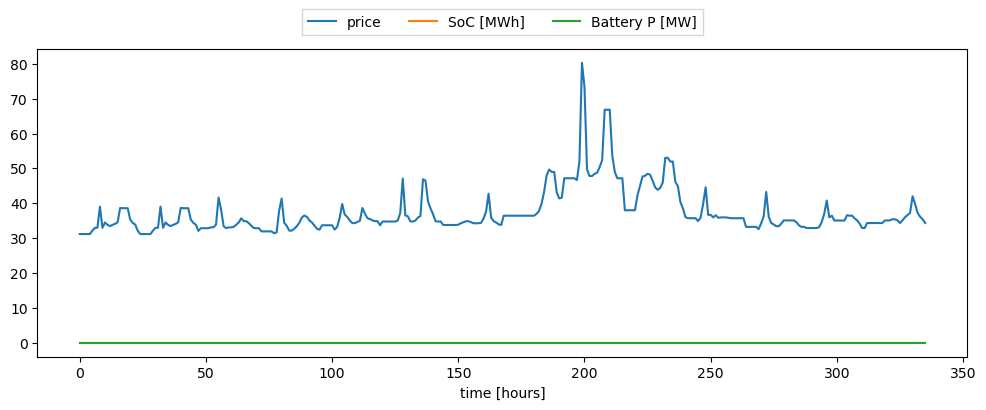

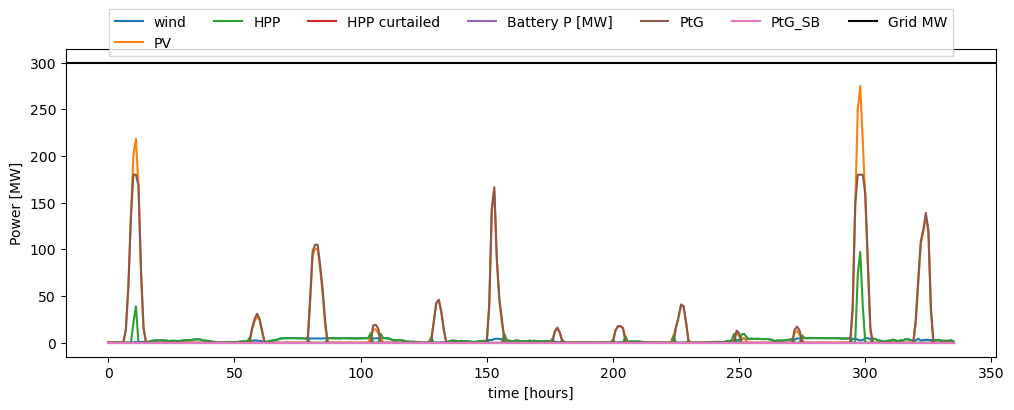

In [127]:
b_E_SOC_t = hpp.prob.get_val('ems.b_E_SOC_t')
b_t = hpp.prob.get_val('ems.b_t')
price_t = hpp.prob.get_val('ems.price_t')

wind_t = hpp.prob.get_val('ems.wind_t')
solar_t = hpp.prob.get_val('ems.solar_t')
hpp_t = hpp.prob.get_val('ems.hpp_t')
hpp_curt_t = hpp.prob.get_val('ems.hpp_curt_t')
P_ptg_t = hpp.prob.get_val('ems.P_ptg_t')
P_ptg_SB_t = hpp.prob.get_val('ems.P_ptg_SB_t')
grid_MW = hpp.prob.get_val('ems.G_MW')

m_H2_t = hpp.prob.get_val('ems.m_H2_t')
m_H2_demand_t = hpp.prob.get_val('ems.m_H2_demand_t_ext')
m_H2_offtake_t = hpp.prob.get_val('ems.m_H2_offtake_t')
LoS_H2_t = hpp.prob.get_val('ems.LoS_H2_t')

n_days_plot = 14
plt.figure(figsize=[12,4])
plt.plot(price_t[:24*n_days_plot], label='price')
plt.plot(b_E_SOC_t[:24*n_days_plot], label='SoC [MWh]')
plt.plot(b_t[:24*n_days_plot], label='Battery P [MW]')
plt.xlabel('time [hours]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=3, fancybox=0, shadow=0)

plt.figure(figsize=[12,4])
plt.plot(wind_t[:24*n_days_plot], label='wind')
plt.plot(solar_t[:24*n_days_plot], label='PV')
plt.plot(hpp_t[:24*n_days_plot], label='HPP')
plt.plot(hpp_curt_t[:24*n_days_plot], label='HPP curtailed')
plt.plot(b_t[:24*n_days_plot], label='Battery P [MW]')
plt.plot(P_ptg_t[:24*n_days_plot], label='PtG')
plt.plot(P_ptg_SB_t[:24*n_days_plot], label='PtG_SB')
plt.axhline(grid_MW, label='Grid MW', color='k')
plt.xlabel('time [hours]')
plt.ylabel('Power [MW]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=7, fancybox=0, shadow=0)


In [128]:
results = {'Wind': wind_t, 'PV': solar_t, 'HPP': hpp_t[:8760], 'Curtailment': hpp_curt_t[:8760],\
                    'Battery power': b_t[:8760], 'Energy Level': b_E_SOC_t[:8760], 'Prices': price_t, 'PtG': P_ptg_t[:8760], 'Mass H2': m_H2_t[:8760], 'PtG_SB': P_ptg_SB_t[:8760],}
df = pd.DataFrame(results)
df.to_csv('EMS_out_9_P2X.csv')

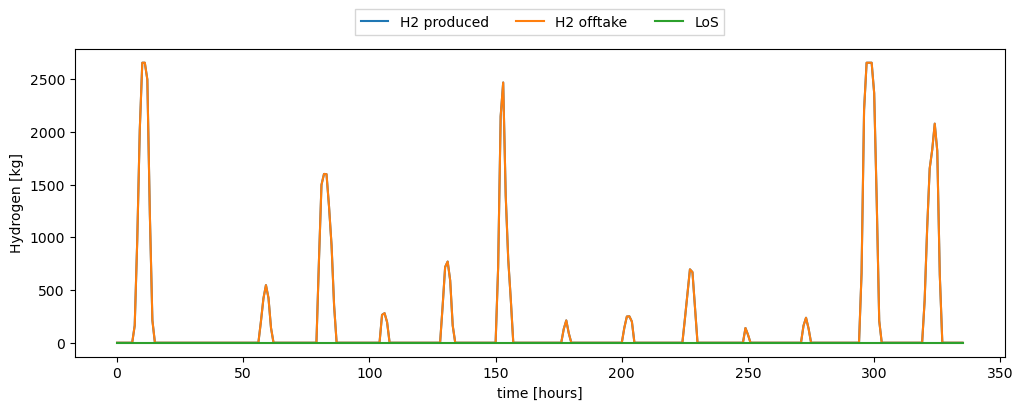

In [129]:

plt.figure(figsize=[12,4])
plt.plot(m_H2_t[:24*n_days_plot], label='H2 produced')
plt.plot(m_H2_offtake_t[:24*n_days_plot], label='H2 offtake')
#plt.plot(m_H2_demand_t[:24*n_days_plot], label='H2 demand')
plt.plot(LoS_H2_t[:24*n_days_plot], label='LoS')
plt.xlabel('time [hours]')
plt.ylabel('Hydrogen [kg]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=5, fancybox=0, shadow=0)